### Libraries and Warning Suppression

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import warnings
warnings.filterwarnings('ignore')

### Helper Function

In [10]:
# Helper function for score aggregation
def aggregate_classes(score):
    if score < 55:
        return "Below 55"
    elif score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

### Load Dataset and Preprocess data

In [11]:
# Load and preprocess data
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Untuned without SMOTE

In [12]:
# Define scorers
scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

In [13]:
# Initial model evaluation (before tuning, before SMOTE)
print("\nEvaluating initial model (before tuning, before SMOTE)...")
initial_rf = RandomForestClassifier(random_state=42)
cv_results = cross_validate(initial_rf, X_scaled, y, cv=5, scoring=scorers)


Evaluating initial model (before tuning, before SMOTE)...


In [14]:
# Calculate metrics before tuning
metrics_before_tuning = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

print("\nMetrics before tuning (original data):")
for metric, (mean, std) in metrics_before_tuning.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")



Metrics before tuning (original data):
Accuracy: Mean = 0.7958, Std = 0.0068
Precision: Mean = 0.7920, Std = 0.0140
Recall: Mean = 0.7958, Std = 0.0068
F1: Mean = 0.7784, Std = 0.0078
AUC: Mean = nan, Std = nan


### Tuned without SMOTE

In [15]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [16]:
# Perform GridSearchCV
print("\nPerforming hyperparameter tuning...")
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                         param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_scaled, y)
best_rf = grid_search.best_estimator_


Performing hyperparameter tuning...


In [17]:
# Evaluate tuned model on original data
cv_results_tuned = cross_validate(best_rf, X_scaled, y, cv=5, scoring=scorers)

# Calculate metrics after tuning
metrics_after_tuning = {
    "Accuracy": (cv_results_tuned['test_accuracy'].mean(), cv_results_tuned['test_accuracy'].std()),
    "Precision": (cv_results_tuned['test_precision'].mean(), cv_results_tuned['test_precision'].std()),
    "Recall": (cv_results_tuned['test_recall'].mean(), cv_results_tuned['test_recall'].std()),
    "F1": (cv_results_tuned['test_f1'].mean(), cv_results_tuned['test_f1'].std()),
    "AUC": (cv_results_tuned['test_roc_auc'].mean(), cv_results_tuned['test_roc_auc'].std())
}

print("\nMetrics after tuning (original data):")
for metric, (mean, std) in metrics_after_tuning.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Metrics after tuning (original data):
Accuracy: Mean = 0.7993, Std = 0.0054
Precision: Mean = 0.7914, Std = 0.0091
Recall: Mean = 0.7993, Std = 0.0054
F1: Mean = 0.7816, Std = 0.0055
AUC: Mean = nan, Std = nan


### Untuned with SMOTE

In [18]:
# Apply SMOTE
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)


Applying SMOTE...


In [19]:
# Evaluate initial model on SMOTE data
cv_results_smote = cross_validate(initial_rf, X_balanced, y_balanced, cv=5, scoring=scorers)

# Calculate metrics before tuning on SMOTE data
metrics_before_smote = {
    "Accuracy": (cv_results_smote['test_accuracy'].mean(), cv_results_smote['test_accuracy'].std()),
    "Precision": (cv_results_smote['test_precision'].mean(), cv_results_smote['test_precision'].std()),
    "Recall": (cv_results_smote['test_recall'].mean(), cv_results_smote['test_recall'].std()),
    "F1": (cv_results_smote['test_f1'].mean(), cv_results_smote['test_f1'].std()),
    "AUC": (cv_results_smote['test_roc_auc'].mean(), cv_results_smote['test_roc_auc'].std())
}

print("\nMetrics before tuning (SMOTE data):")
for metric, (mean, std) in metrics_before_smote.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Metrics before tuning (SMOTE data):
Accuracy: Mean = 0.9531, Std = 0.0176
Precision: Mean = 0.9559, Std = 0.0156
Recall: Mean = 0.9531, Std = 0.0176
F1: Mean = 0.9533, Std = 0.0167
AUC: Mean = nan, Std = nan


### Tuned with SMOTE

In [20]:
# Final model tuning on SMOTE data
print("\nPerforming final hyperparameter tuning on SMOTE data...")
grid_search_final = GridSearchCV(RandomForestClassifier(random_state=42), 
                               param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_final.fit(X_balanced, y_balanced)
best_rf_final = grid_search_final.best_estimator_


Performing final hyperparameter tuning on SMOTE data...


In [21]:
# Final evaluation
cv_results_final = cross_validate(best_rf_final, X_balanced, y_balanced, cv=5, scoring=scorers)

# Calculate final metrics
metrics_after_smote = {
    "Accuracy": (cv_results_final['test_accuracy'].mean(), cv_results_final['test_accuracy'].std()),
    "Precision": (cv_results_final['test_precision'].mean(), cv_results_final['test_precision'].std()),
    "Recall": (cv_results_final['test_recall'].mean(), cv_results_final['test_recall'].std()),
    "F1": (cv_results_final['test_f1'].mean(), cv_results_final['test_f1'].std()),
    "AUC": (cv_results_final['test_roc_auc'].mean(), cv_results_final['test_roc_auc'].std())
}

print("\nFinal metrics (tuned model on SMOTE data):")
for metric, (mean, std) in metrics_after_smote.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Final metrics (tuned model on SMOTE data):
Accuracy: Mean = 0.9560, Std = 0.0170
Precision: Mean = 0.9586, Std = 0.0150
Recall: Mean = 0.9560, Std = 0.0170
F1: Mean = 0.9562, Std = 0.0163
AUC: Mean = nan, Std = nan


### Final Evaluations

In [27]:
# Split data for final predictions
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train final model and make predictions
best_rf_final.fit(X_train, y_train)
y_pred = best_rf_final.predict(X_test)

print("\nBest parameters:", grid_search_final.best_params_)
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Final Classification Report:
              precision    recall  f1-score   support

       55-60       0.99      1.00      0.99       656
       61-65       0.94      0.90      0.92       733
       66-70       0.85      0.89      0.87       635
       71-75       0.96      0.95      0.95       664
       76-80       1.00      1.00      1.00       715
         81+       1.00      1.00      1.00       669

    accuracy                           0.96      4072
   macro avg       0.96      0.96      0.96      4072
weighted avg       0.96      0.96      0.96      4072

Final Test Set Accuracy: 0.9568


### Data Visualization

In [22]:
# Visualization functions
def plot_class_distribution():
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    original_distribution = pd.Series(y).value_counts()
    plt.bar(original_distribution.index, original_distribution.values)
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    balanced_distribution = pd.Series(y_balanced).value_counts()
    plt.bar(balanced_distribution.index, balanced_distribution.values)
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_metrics_comparison():
    metrics = {
        "Accuracy": [metrics_before_tuning["Accuracy"][0], 
                    metrics_after_tuning["Accuracy"][0],
                    metrics_before_smote["Accuracy"][0], 
                    metrics_after_smote["Accuracy"][0]],
        "Precision": [metrics_before_tuning["Precision"][0],
                     metrics_after_tuning["Precision"][0],
                     metrics_before_smote["Precision"][0],
                     metrics_after_smote["Precision"][0]],
        "Recall": [metrics_before_tuning["Recall"][0],
                  metrics_after_tuning["Recall"][0],
                  metrics_before_smote["Recall"][0],
                  metrics_after_smote["Recall"][0]],
        "F1 Score": [metrics_before_tuning["F1"][0],
                    metrics_after_tuning["F1"][0],
                    metrics_before_smote["F1"][0],
                    metrics_after_smote["F1"][0]],
        "AUC": [metrics_before_tuning["AUC"][0],
                metrics_after_tuning["AUC"][0],
                metrics_before_smote["AUC"][0],
                metrics_after_smote["AUC"][0]]
    }
    
    metrics_df = pd.DataFrame(metrics, 
                            index=["Before Tuning", "After Tuning",
                                  "SMOTE Before Tuning", "SMOTE After Tuning"])
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap="viridis")
    plt.title("Performance Metrics Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

In [24]:
def plot_confusion_matrix():
    # Split data for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    best_rf_final.fit(X_train, y_train)
    y_pred = best_rf_final.predict(X_test)
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [25]:
def plot_feature_importance():
    plt.figure(figsize=(12, 8))
    importances = best_rf_final.feature_importances_
    indices = np.argsort(importances)
    plt.barh(range(len(importances)), importances[indices])
    plt.yticks(range(len(importances)), [X.columns[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

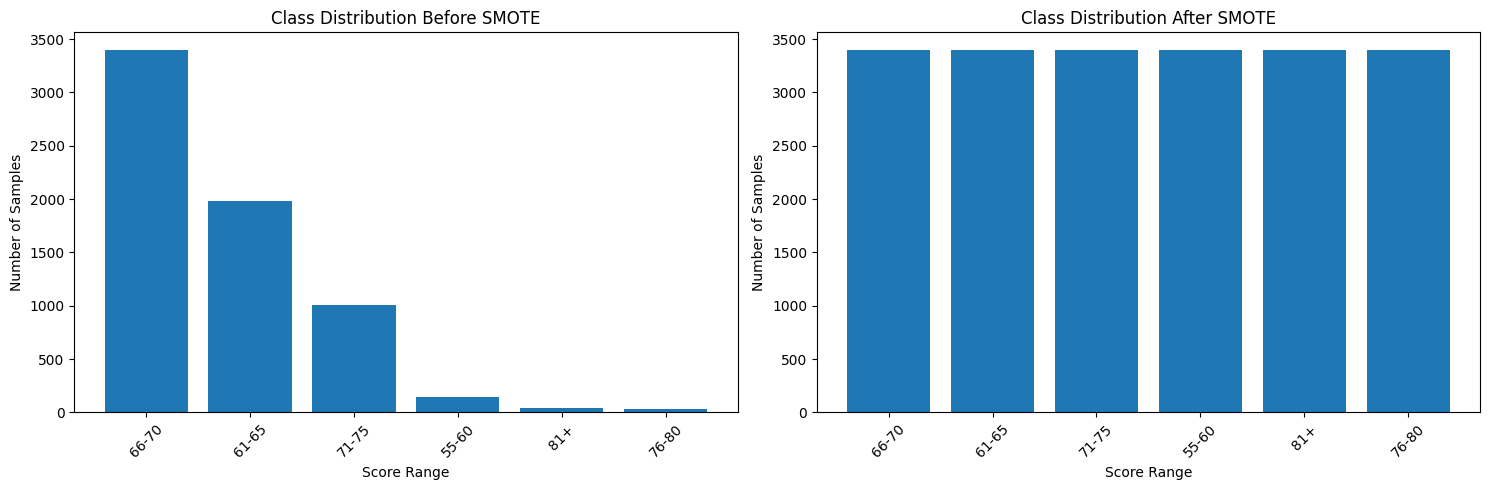

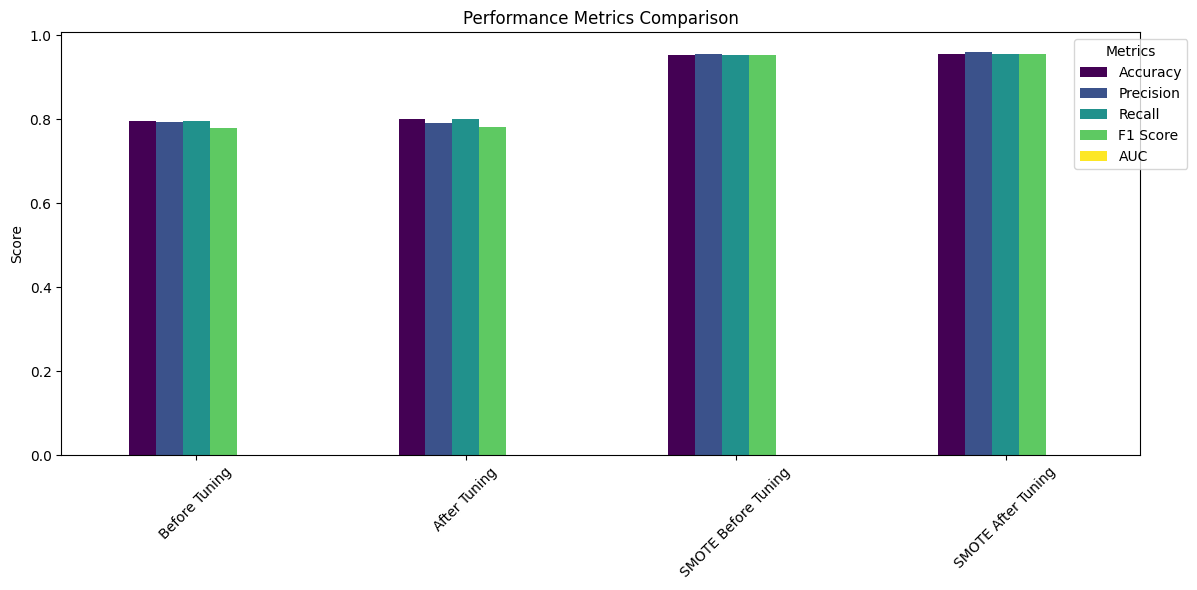

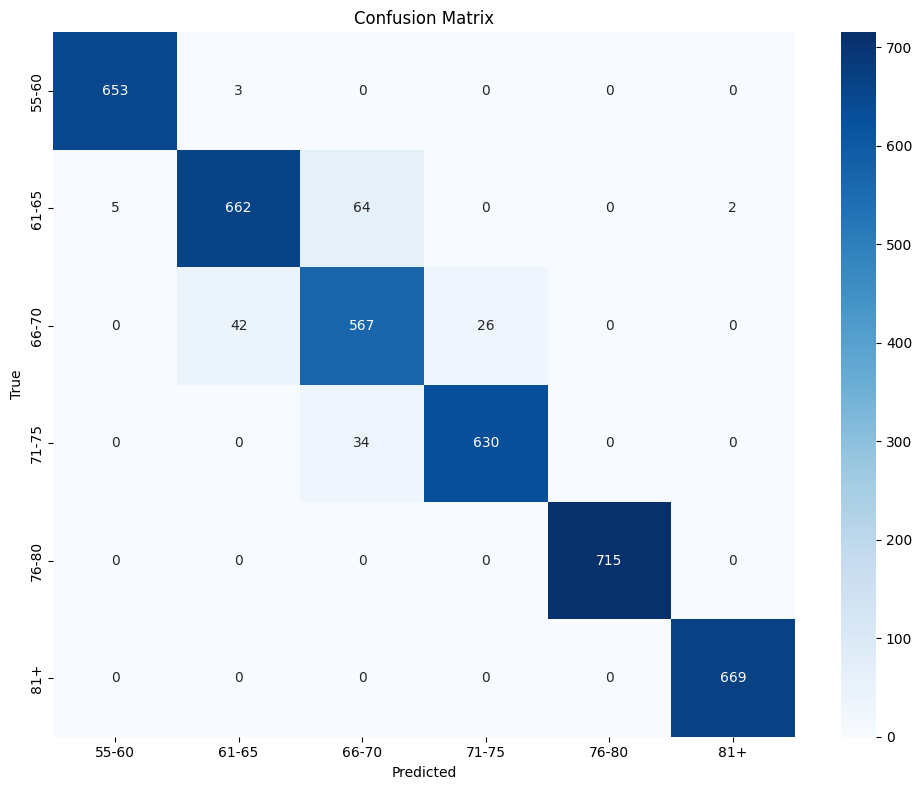

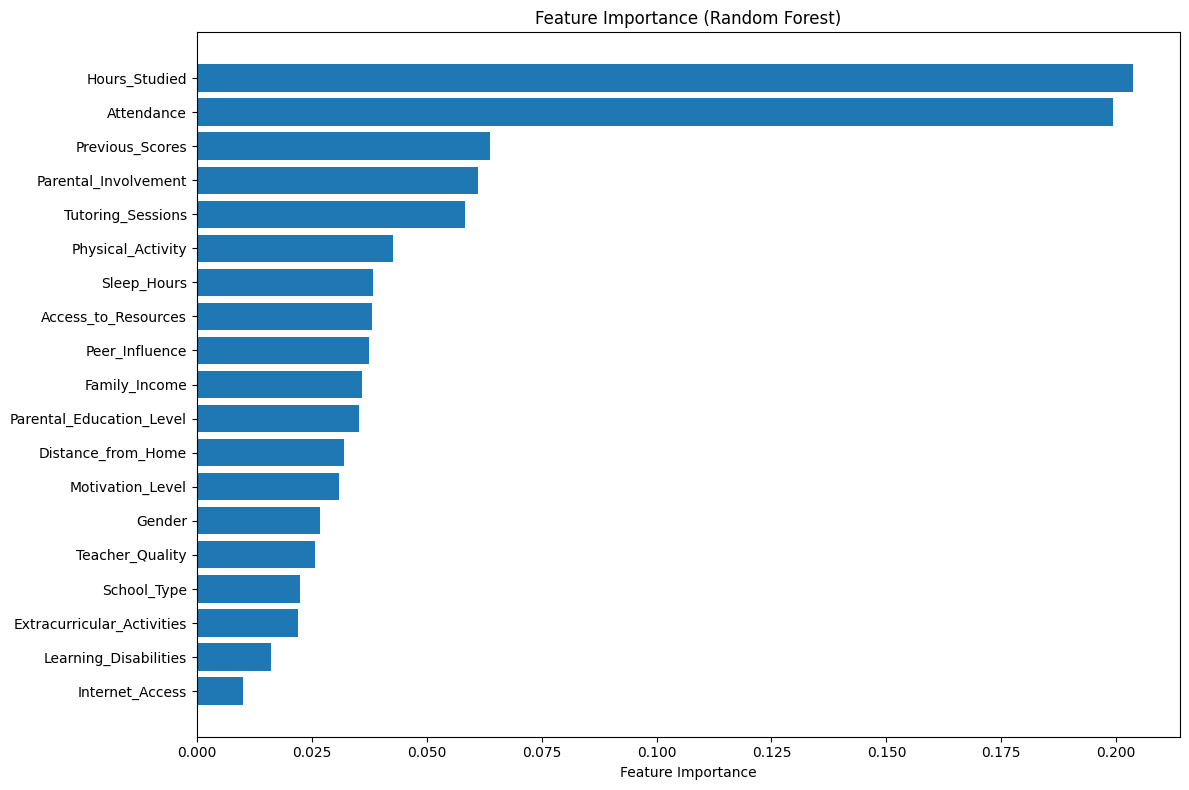

In [26]:
# Generate plots
plot_class_distribution()
plot_metrics_comparison()
plot_confusion_matrix()
plot_feature_importance()